In [185]:
import os 
import numpy as np
import pandas as pd
import importlib as imp
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.simplefilter('ignore')
pd.options.display.max_columns = 100


Ваша последняя лабораторная работа будет заключаться в реализации одного из двух алгоритмов, <br>подсказанных природой, для решении задачи vehicle routing problem:

1) Алгоритм колонии муравьев
2) Алгоритм колонии пчел

Данные:

Прикрепил в архиве. Формат такой:<br>
1-6 строчки - доп. информация про бенчмарку, No of trucks - количество грузовиков, CAPACITY - вместимость грузовика.<br>
7 строчка NODE_COORD_SECTION - начало данных про пункты<br>
1 17 36 - 1 пункт, координата по x - 17, координата по y - 36<br>
...<br>
Строчка DEMAND_SECTION - начало информации про требуемое количество материала для пункта<br>
7 9 - 7 пункт, 9 - требуемое количество материала. Если требуется 0 - этот пункт склад.<br>

Формат выходных данных, которые нужно выслать по каждой бенчмарке - приложил как файл B-n78-k10.sol в архиве.<br>

Форма отчетности:<br>

Вы присылаете мне код алгоритма и файлы с ответами. Работать можно в группах не более 3-х человек. Прогнать нужно на <br>всех данных. Код и ответы можно прислать мне на почту (epburashnikov@hse.ru). В теме письма укажите: "АИО Лаб. 5 <br>Имя Фамилия", где вместо Имя Фамилия укажите ваши реальные Имя и Фамилию, например, АИО Лаб. 5 Ян Лекун.<br>

Дедлайн: 07.06.2020 23:59<br>

In [71]:
from utils import tools
tools = imp.reload(tools)

In [112]:
problem = tools.get_problem('benchmarks/B/B-n31-k5.vrp')

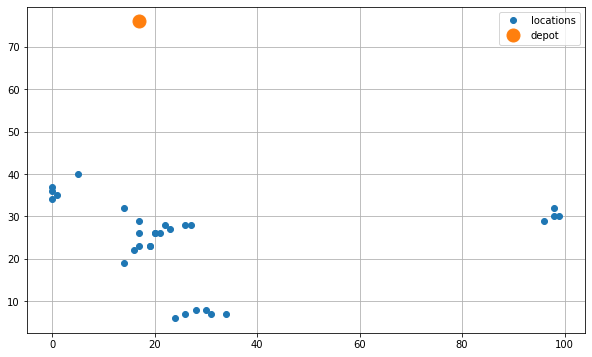

In [186]:
tools = imp.reload(tools)
tools.visualize_problem(problem)

In [191]:
tools = imp.reload(tools)
solution  = tools.generate_solution(problem)

In [197]:
isinstance(solution, np.array([]))

TypeError: isinstance() arg 2 must be a type or tuple of types

<class 'numpy.ndarray'>


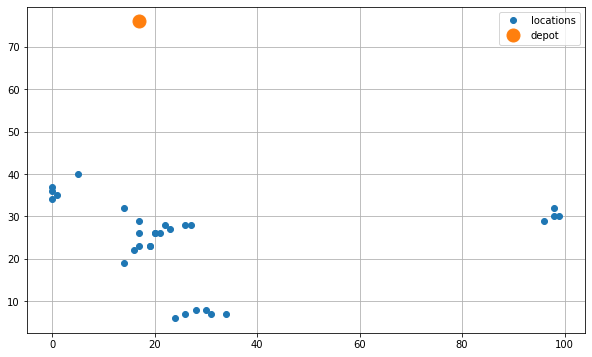

In [193]:
tools.visualize_problem(problem, solution)